### Imputing Missing Data
* Scikit-learn does not support missing values as input, so we need to remove observations with missing data or transform them into permitted values
* The act of replacing missing data with statistical estimates of missing values is called imputation
* The choice of imputation technique we use will depend on whether the data is missing at random, the number of missing values, and the machine learning model we intend to use

### 1. Removing observations with missing data
* Complete Case Analysis (CCA) consists of discarding those observations where the values in any of the variables are missing
* CCA can be applied to categorical and numerical variables
* CCA is quick and easy to implement and has the advantage that it preserves the distribution of the variables, provided the data is missing at random and only a small proportion of the data is missing
* However, if data is missing across many variables, CCA may lead to the removal of a big portion of the dataset

### 2. Performing mean or median imputation

* Mean or median imputation consists of replacing missing values with the variable mean or median
* This can only be performed in numerical variables
* The mean or the median is calculated using a train set, and these values are used to impute missing data in train and test sets
* Use mean imputation if variables are normally distributed and median imputation otherwise
* Mean and median imputation may distort the distribution of the original variables if there is a high percentage of missing data

### 3. Implementing mode or frequent category imputation
* Mode imputation consists of replacing missing values with the mode
* We normally use this procedure in categorical variables
* If the percentage of missing values is high, frequent category imputation may distort the original distribution of categories
*  unlike SimpleImputer() from scikit-learn, FrequentCategoryImputer() will only impute categorical variables and ignores numerical ones

### 4. Replacing missing values with an arbitrary number
* This method is suitable for numerical variables
* When replacing missing values with an arbitrary number, we need to be careful not to select a value close to the mean or the median, or any other common value of the distribution
* Arbitrary number imputation can be used when data is not missing at random, when we are building non-linear models, and when the percentage of missing data is high
* This imputation technique distorts the original variable distribution
* we select arbitrary values that are bigger than the maximum value of the distribution
* ArbitraryNumberImputer() will automatically select all numerical variables in the train set; that is, unless we specify which variables to impute in a list

### 5. Capturing missing values in a bespoke category
* Missing data in categorical variables can be treated as a different category, so it is common to replace missing values with the Missing string
* SimpleImputer() from scikit-learn will replace missing values with Missing in both numerical and categorical variables. Be careful of this behavior or you will end up accidentally casting your numerical variables as objects

### 6. Replacing missing values with a value at the end of the distribution
* Replacing missing values with a value at the end of the variable distribution is equivalent to replacing them with an arbitrary value, but instead of identifying the arbitrary values manually, these values are automatically selected as those at the very end of the variable distribution
* The values that are used to replace missing information are estimated using the mean plus or minus three times the standard deviation if the variable is normally distributed, or the inter-quartile range (IQR) proximity rule otherwise
* End-of-tail imputation may distort the distribution of the original variables, so it may not be suitable for linear models

### 7. Implementing random sample imputation
* Random sampling imputation consists of extracting random observations from the pool of available values in the variable
* Random sampling imputation preserves the original distribution, which differs from the other imputation techniques

* We can only use one pandas Series to replace values in another pandas Series if their indexes are identical, so re-index the extracted random values so that they match the index of the missing values in the original dataframe

### 8. Adding a missing value indicator variable
* if the data was missing at random, this would be contemplated by the mean, median, or mode imputation, and if it wasn't, this would be captured by the missing indicator





In [1]:
# importing necessary libraries
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import EndTailImputer
from feature_engine.imputation import RandomSampleImputer
from feature_engine.imputation import AddMissingIndicator

In [2]:
# Dataset preparation steps
df = pd.read_csv(r"C:\Users\Honey\Desktop\Feature_Engineering_Cookbook\Datasets\crx.data",header=None)
varnames = ['A'+str(s) for s in range(1,17)]
df.columns = varnames

df = df.replace("?",np.nan)
df["A2"] = df["A2"].astype('float') # Recast the numerical variables as float data types
df["A14"] = df["A14"].astype('float')
df["A16"] = df["A16"].map({"+":1,"-":0}) # Recode the target variable as binary

# Add some missing values at random positions
random.seed(9001)
values = list(set([random.randint(0,len(df)) for p in range(0,100)]))
for var in ["A3","A8","A9","A10"]:
    df.loc[values,var] = np.nan

df.to_csv(r'C:\Users\Honey\Desktop\Feature_Engineering_Cookbook\Datasets\creditApprovalUCI.csv',index=False)

In [3]:
df = pd.read_csv(r'C:\Users\Honey\Desktop\Feature_Engineering_Cookbook\Datasets\creditApprovalUCI.csv')
df.isnull().mean().sort_values(ascending=True)
df_cca = df.dropna(how='all') #  To remove observations if data is missing in all the variables
df_cca = df.dropna(subset=["A3","A4"]) # To remove observations where data is missing in a subset of variables
df_cca = df.dropna()
df_cca.isnull().mean()
print("NUmber of total observations: {}".format(len(df)))
print("Number of observations with complete cases: {}".format(len(df_cca)))

NUmber of total observations: 690
Number of observations with complete cases: 564


### Missing values imputation using Pandas

In [4]:
df = pd.read_csv(r'C:\Users\Honey\Desktop\Feature_Engineering_Cookbook\Datasets\creditApprovalUCI.csv')
x_train,x_test,y_train,y_test = train_test_split(df.drop("A16",axis=1), df["A16"], test_size=0.3,random_state=0)
x_train.shape, x_test.shape
x_train.isnull().mean()

for var in ["A2","A3","A8","A11","A15"]:
    value = x_train[var].mean() # mean imputation
    value = x_train[var].median() # median imputation
    value = x_train[var].mode()[0] # mode imputation
    value = 99 # Arbitrary number imputation
    value = "Missing" # treating missing values in categorical variables
    
    # end tail imputation
    IQR = x_train[var].quantile(0.75) - x_train[var].quantile(0.25)
    value = x_train[var].quantile(0.75) + 1.5*IQR
    value = x_train[var].quantile(0.25) - 1.5*IQR
    value = x_train[var].mean() + 3*x_train[var].std()
    value = x_train[var].mean() - 3*x_train[var].std()
    value = x_train[var].max()*3    
    
    x_train[var].fillna(value,inplace=True)
    x_test[var] = x_test[var].fillna(value)

# random sample imputation
for var in ["A1","A3","A4","A5","A6","A7","A8"]:
    # extract a random sample
    random_sample_train = x_train[var].dropna().sample(x_train[var].isnull().sum(),random_state=0)
    random_sample_test = x_train[var].dropna().sample(x_test[var].isnull().sum(),random_state=0)
    # re-index the randomly extracted sample
    random_sample_train.index = x_train[x_train[var].isnull()].index
    random_sample_test.index = x_test[x_test[var].isnull()].index
    # replace the NA
    x_train.loc[x_train[var].isnull(),var] = random_sample_train
    x_test.loc[x_test[var].isnull(),var] = random_sample_test

# adding a missing value indicator variable
for var in ["A1","A3","A4","A5","A6","A7","A8"]:
    x_train[var+"_NA"] = np.where(x_train[var].isnull(),1,0)
    x_test[var+"_NA"] = np.where(x_test[var].isnull(),1,0)

### Missing values imputation using scikit-learn

In [5]:
x_train,x_test,y_train,y_test = train_test_split(df[["A2","A3","A8","A11","A15"]],df["A16"],test_size=0.3,random_state=0)
imputer = SimpleImputer(strategy='mean')
imputer = SimpleImputer(strategy='median')
imputer = SimpleImputer(strategy='most_frequent')
imputer = SimpleImputer(strategy="constant",fill_value=99) 
# imputer = SimpleImputer(strategy='constant',fill_value='Missing')
# imputer = SimpleImputer(strategy='mean', add_indicator=True)

imputer.fit(x_train) # learns the median values of the variables
imputer.statistics_ # inspect the learned median values
x_train = imputer.transform(x_train) # replace missing values with medians
x_test = imputer.transform(x_test)
x_train = pd.DataFrame(x_train,columns=["A2","A3","A8","A11","A15"])

# adding a missing value indicator variable
indicator = MissingIndicator(features='missing-only')
indicator.fit(x_train)
indicator_cols = [c+"_NA" for c in x_train.columns[indicator.features_]]
x_train = pd.concat([x_train.reset_index(), pd.DataFrame(indicator.transform(x_train),columns=indicator_cols)],axis=1)

### Missing values imputation using Feature-engine

In [6]:
x_train,x_test,y_train,y_test = train_test_split(df[["A2","A3","A8","A11","A15"]],df["A16"],test_size=0.3,random_state=0)

imputer = MeanMedianImputer(imputation_method="mean",variables=["A2","A3","A8","A11","A15"])
imputer = MeanMedianImputer(imputation_method="median",variables=["A2","A3","A8","A11","A15"])
imputer = CategoricalImputer(imputation_method='frequent',variables = ["A4","A5","A6","A7"])
imputer = ArbitraryNumberImputer(arbitrary_number=99,variables= ["A2","A3","A8","A11"])
imputer = CategoricalImputer(variables = ['A4', 'A5', 'A6', 'A7'])
imputer = EndTailImputer(imputation_method="iqr",tail="right",variables = ['A2','A3', 'A8', 'A11', 'A15'])
imputer = EndTailImputer(imputation_method="gaussian",tail="left",variables = ['A2','A3', 'A8', 'A11', 'A15'])
# imputer = RandomSampleImputer(variables=["A2","A3","A8","A11","A15"], random_state=0)
# imputer = AddMissingIndicator(variables = ['A2', 'A3'])

imputer.fit(x_train)
imputer.imputer_dict_
x_train = imputer.transform(x_train)
x_test = imputer.transform(x_test)

### 9. Performing multivariate imputation by chained equations
* It is a multiple imputation technique that models each variable with missing values as a function of the remaining variables and uses that estimate for imputation
* Each variable with missing data can be modeled based on the remaining variable by using multiple approaches, for example, linear regression, Bayes, decision trees, k-nearest neighbors, and random forests.

C:\Users\Honey\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Honey\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


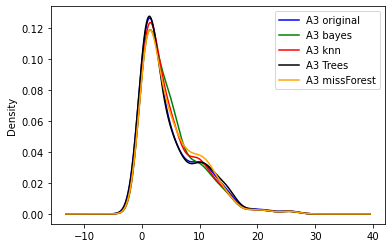

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

variables = ['A2','A3','A8', 'A11', 'A14', 'A15', 'A16']
data = pd.read_csv(r'C:\Users\Honey\Desktop\Feature_Engineering_Cookbook\Datasets\creditApprovalUCI.csv', usecols=variables)
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

imputer_bayes = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)
imputer_knn = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5), max_iter=10, random_state=0)
imputer_nonLin=IterativeImputer(estimator=DecisionTreeRegressor(max_features='sqrt',random_state=0),max_iter=10,random_state=0)
imputer_missForest = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),max_iter=10,random_state=0)

imputer_bayes.fit(X_train)
imputer_knn.fit(X_train)
imputer_nonLin.fit(X_train)
imputer_missForest.fit(X_train)

X_train_bayes = imputer_bayes.transform(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_train_nonLin = imputer_nonLin.transform(X_train)
X_train_missForest = imputer_missForest.transform(X_train)

predictors = [var for var in variables if var !='A16']
X_train_bayes = pd.DataFrame(X_train_bayes, columns = predictors)
X_train_knn = pd.DataFrame(X_train_knn, columns = predictors)
X_train_nonLin = pd.DataFrame(X_train_nonLin, columns = predictors)
X_train_missForest = pd.DataFrame(X_train_missForest, columns = predictors)

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['A3'].plot(kind='kde', ax=ax, color='blue')
X_train_bayes['A3'].plot(kind='kde', ax=ax, color='green')
X_train_knn['A3'].plot(kind='kde', ax=ax, color='red')
X_train_nonLin['A3'].plot(kind='kde', ax=ax, color='black')
X_train_missForest['A3'].plot(kind='kde', ax=ax, color='orange')
# add legends
lines, labels = ax.get_legend_handles_labels()
labels = ['A3 original', 'A3 bayes', 'A3 knn', 'A3 Trees', 'A3 missForest']
ax.legend(lines, labels, loc='best')
plt.show()

### 10. Assembling an imputation pipeline with scikit-learn
* Datasets often contain a mix of numerical and categorical variables. In addition, some variables may contain a few missing data points, while others will contain quite a big proportion. The mechanisms by which data is missing may also vary among variables



In [8]:

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

data = pd.read_csv(r'C:\Users\Honey\Desktop\Feature_Engineering_Cookbook\Datasets\creditApprovalUCI.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

features_num_arbitrary = ['A3', 'A8']
features_num_median = ['A2', 'A14']
features_cat_frequent = ['A4', 'A5', 'A6', 'A7']
features_cat_missing = ['A1', 'A9', 'A10']

imputer_num_arbitrary = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=99)),])
imputer_num_median = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),])
imputer_cat_frequent = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),])
imputer_cat_missing = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant',fill_value='Missing')),])

preprocessor = ColumnTransformer(transformers=[('imp_num_arbitrary', imputer_num_arbitrary, features_num_arbitrary),
                                                 ('imp_num_median', imputer_num_median, features_num_median),
                                                 ('imp_cat_frequent', imputer_cat_frequent, features_cat_frequent),
                                                 ('imp_cat_missing', imputer_cat_missing, features_cat_missing),],
                                 remainder='passthrough')
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

### 11. Assembling an imputation pipeline with Feature-engine

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer


data = pd.read_csv(r'C:\Users\Honey\Desktop\Feature_Engineering_Cookbook\Datasets\creditApprovalUCI.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

features_num_arbitrary = ['A3', 'A8']
features_num_median = ['A2', 'A14']
features_cat_frequent = ['A4', 'A5', 'A6', 'A7']
features_cat_missing = ['A1', 'A9', 'A10']

pipe = Pipeline(steps=[('imp_num_arbitrary', ArbitraryNumberImputer(variables = features_num_arbitrary)),
                     ('imp_num_median', MeanMedianImputer(imputation_method = 'median', variables=features_num_median)),
                     ('imp_cat_frequent', CategoricalImputer(imputation_method='frequent',variables = features_cat_frequent)),
                     ('imp_cat_missing', CategoricalImputer(imputation_method='missing',variables=features_cat_missing))])
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)